In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用黑体显示中文

In [16]:
filepath = './data/GSPC.csv'
data = pd.read_csv(filepath)
print(data.head())
print(data.shape)

           开盘          最高          最低          收盘       成交量
0  107.940002  108.430000  105.290001  105.760002  40610000
1  105.760002  106.080002  103.260002  105.220001  50480000
2  105.220001  107.080002  105.089996  106.519997  39130000
3  106.519997  107.800003  105.800003  106.809998  44500000
4  106.809998  109.290001  106.290001  108.949997  53390000
(10057, 5)


In [17]:
data.rename(columns={"收盘":"Close"}, inplace=True)

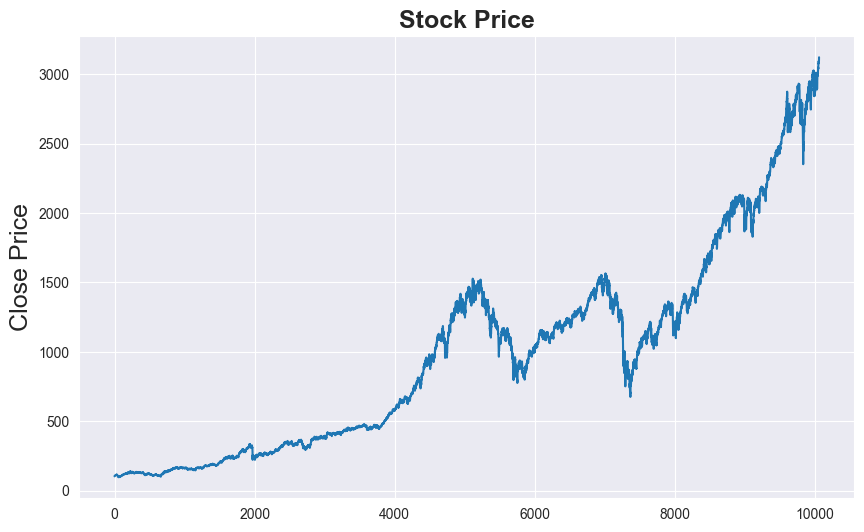

In [18]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
plt.plot(data[['Close']])
# plt.xticks(range(0, data.shape[0], 20), data['Date'].loc[::20], rotation=45)
plt.title("Stock Price", fontsize=18, fontweight='bold')
# plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.show()

In [19]:
# 1.特征工程
# 选取Close作为特征
price = data[['Close']]
print(price.info())

from sklearn.preprocessing import MinMaxScaler
# 进行不同的数据缩放，将数据缩放到-1和1之间
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1, 1))
print(price['Close'].shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10057 entries, 0 to 10056
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   10057 non-null  float64
dtypes: float64(1)
memory usage: 78.7 KB
None
(10057,)


C:\Users\yjp\AppData\Local\Temp\ipykernel_24756\1344573063.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
# 2.数据集制作
# 今天的收盘价预测明天的收盘价
# lookback表示观察的跨度
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    # print(data)

    # you can free play（seq_length）
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data);
    test_set_size = int(np.round(0.25 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]

    return [x_train, y_train, x_test, y_test]

In [21]:
lookback = 20
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (7528, 19, 1)
y_train.shape =  (7528, 1)
x_test.shape =  (2509, 19, 1)
y_test.shape =  (2509, 1)


In [22]:
# 注意：pytorch的nn.LSTM input shape=(seq_length, batch_size, input_size)
# 3.模型构建 —— LSTM

import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)
# 输入的维度为1，只有Close收盘价
input_dim = 1
# 隐藏层特征的维度
hidden_dim = 32
# 循环的layers
num_layers = 2
# 预测后一天的收盘价
output_dim = 1
num_epochs = 200

In [23]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [24]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [25]:
# 4.模型训练
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.45663100481033325
Epoch  1 MSE:  0.290184885263443
Epoch  2 MSE:  0.11195272952318192
Epoch  3 MSE:  0.17407873272895813
Epoch  4 MSE:  0.09872046858072281
Epoch  5 MSE:  0.0658314973115921
Epoch  6 MSE:  0.08194193243980408
Epoch  7 MSE:  0.09515943378210068
Epoch  8 MSE:  0.09449339658021927
Epoch  9 MSE:  0.08345524221658707
Epoch  10 MSE:  0.06880692392587662
Epoch  11 MSE:  0.057907428592443466
Epoch  12 MSE:  0.05593900382518768
Epoch  13 MSE:  0.06097446382045746
Epoch  14 MSE:  0.06296198815107346
Epoch  15 MSE:  0.0552670918405056
Epoch  16 MSE:  0.04256231710314751
Epoch  17 MSE:  0.03307180479168892
Epoch  18 MSE:  0.029179725795984268
Epoch  19 MSE:  0.026124753057956696
Epoch  20 MSE:  0.017202405259013176
Epoch  21 MSE:  0.004704310558736324
Epoch  22 MSE:  0.006125606130808592
Epoch  23 MSE:  0.01256227120757103
Epoch  24 MSE:  0.007185472175478935
Epoch  25 MSE:  0.006679187063127756
Epoch  26 MSE:  0.012053054757416248
Epoch  27 MSE:  0.009368170984089

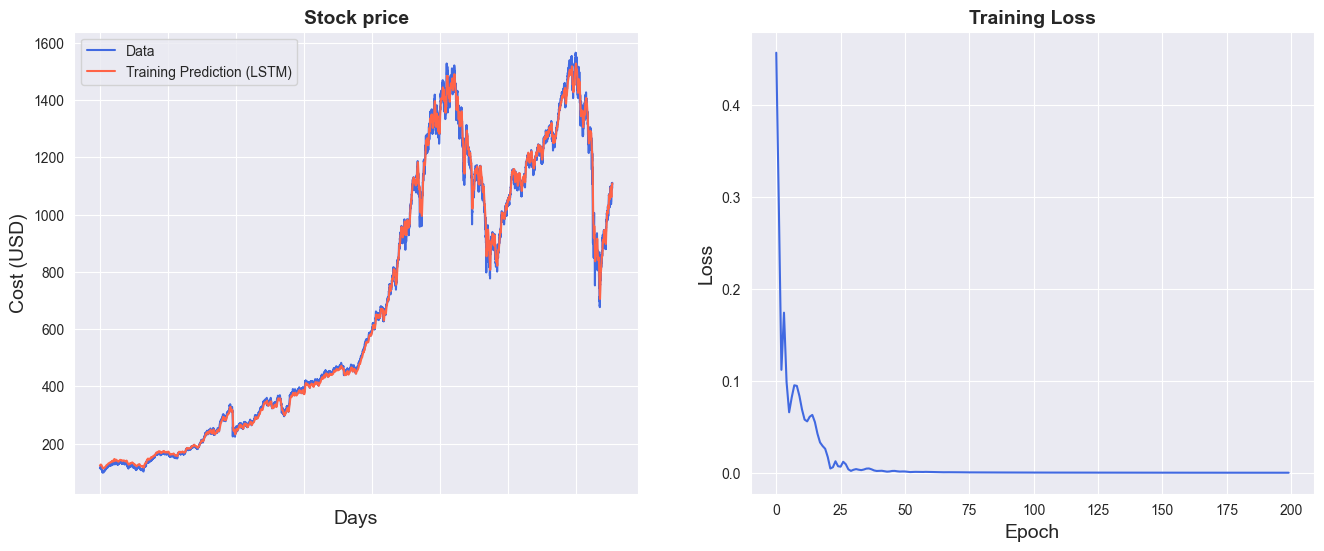

In [26]:
# 5.模型结果可视化

predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
# print(predict.index)
# print(predict[0])


ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)
plt.show()

In [27]:
# 6.模型验证
# print(x_test[-1])
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)


# In[40]:


# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

Train Score: 16.83 RMSE
Test Score: 339.53 RMSE


In [28]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()